In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
df = pd.read_csv('Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [ ]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=20)

In [ ]:
df.head()

,Text,Sentiment
1155,bought a little aapl at 510 ... pressing my po...,1
3659,"FOD continuing to act nicely, 2.90-3.00 potent...",1
1194,"AAP breaks low from 1/15. I'm just saying, ev...",-1
4441,user: AAP Bears are finally getting trapped an...,1
2560,FT another watch list added yesterday that tri...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 1155 to 2703
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 135.7+ KB


# One hot embedding + CNN

In [ ]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(text_train)
 Xcnn_train = tokenizer.texts_to_sequences(text_train)
 Xcnn_test = tokenizer.texts_to_sequences(text_test)
 vocab_size = len(tokenizer.word_index)+1
 print(text_train[1])
 print(Xcnn_train[1]) 

GS exploded in the last hour. Green bars since 1.
[190, 4051, 5, 1, 110, 652, 119, 1226, 141, 27]


In [ ]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 150
 Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
 Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
 print(Xcnn_train[0, :]) 

[1573  102   34   16  421    2   93   32    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
from keras.models import Sequential
from keras import layers 
import tensorflow as tf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          1789800   
                                                                 
 conv1d (Conv1D)             (None, 149, 256)          102656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 128)           98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 64)            3

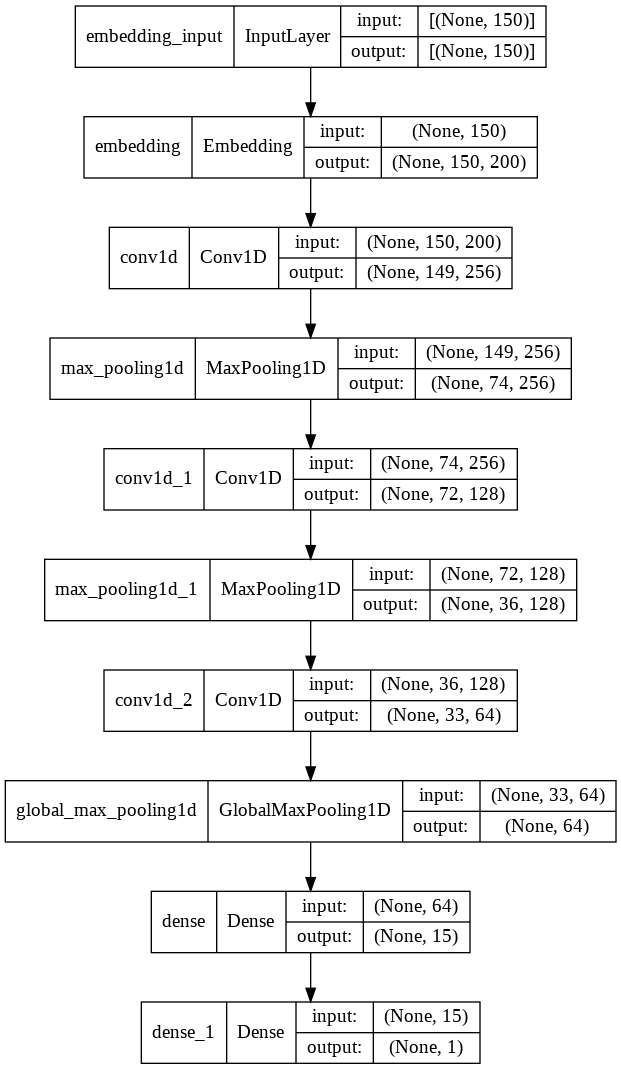

In [ ]:
seed = 160104069
torch.manual_seed(seed)
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(15, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)

In [ ]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
464/464 [==============================] - 31s 65ms/step - loss: -43922.8320 - accuracy: 0.2174 - val_loss: -616753.0625 - val_accuracy: 0.3080
Epoch 2/10
464/464 [==============================] - 30s 65ms/step - loss: -32431788.0000 - accuracy: 0.2852 - val_loss: -163126896.0000 - val_accuracy: 0.2485
Epoch 3/10
464/464 [==============================] - 32s 68ms/step - loss: -940799104.0000 - accuracy: 0.2854 - val_loss: -2755480064.0000 - val_accuracy: 0.2433
Epoch 4/10
464/464 [==============================] - 31s 67ms/step - loss: -8853246976.0000 - accuracy: 0.2921 - val_loss: -19374585856.0000 - val_accuracy: 0.2252
Epoch 5/10
464/464 [==============================] - 30s 65ms/step - loss: -42839916544.0000 - accuracy: 0.2925 - val_loss: -70506938368.0000 - val_accuracy: 0.2476
Epoch 6/10
464/464 [==============================] - 30s 65ms/step - loss: -140324519936.0000 - accuracy: 0.2990 - val_loss: -201526984704.0000 - val_accuracy: 0.2355
Epoch 7/10
464/464 [==

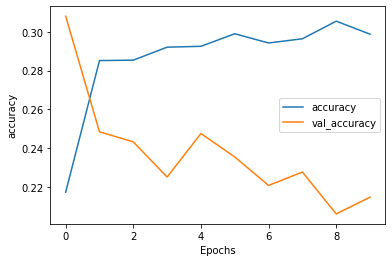

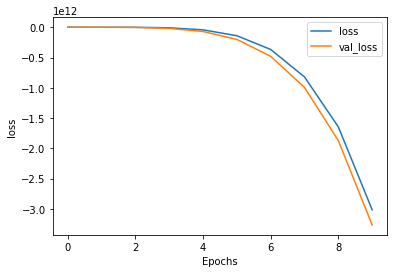

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = textcnnmodel.predict(Xcnn_train)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 5s 33ms/step - loss: -4026088030208.0000 - accuracy: 0.3264


In [ ]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(label_train, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -4026088030208.0
Train Accuracy: 0.32642486691474915 (Model Metric)
Train Accuracy: 0.6699050086355786 (sklearn Metric)
Train Precision: 0.9630573248407643
Train Recall: 0.5068722762319813
Train F1-score: 0.6641774654074237


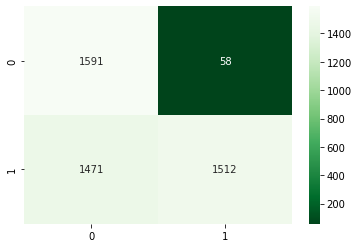

In [ ]:
sns.heatmap(confusion_matrix(label_train, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

In [ ]:
y_pred = textcnnmodel.predict(Xcnn_test)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

Test Accuracy: 0.5875754961173425 (sklearn Metric)


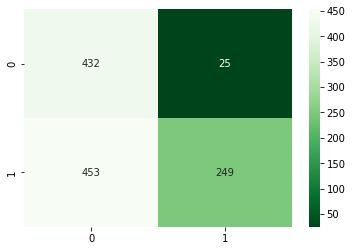

In [ ]:
print('Test Accuracy:', accuracy_score(label_test, y_pred), '(sklearn Metric)')
sns.heatmap(confusion_matrix(label_test, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

# BOW + NN

In [ ]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'hadn', 'ours', 'i', "doesn't", 'we', 'won', 'didn', 'this', 'above', "won't", 'when', 'off', 'wasn', "you'll", "mustn't", 'whom', 'm', "weren't", 'his', 'been', 'once', "shouldn't", 'a', "isn't", "you'd", 'over', 'who', 'did', 'just', 'it', 'where', 'aren', 'only', 't', 'those', 'than', 'an', 'is', 'haven', 'were', 'such', 'weren', 'for', 'd', 'he', "it's", 'hasn', 'itself', "should've", 'needn', 'don', 'its', 'few', 'below', 'these', 'll', 'into', "you've", 'be', 'what', 'should', 'mustn', 'here', 'her', 'do', 'by', 's', 'most', 'under', 'with', "hasn't", 'isn', 'shan', 'or', 'as', "didn't", 'mightn', 'if', 'from', 'has', "mightn't", 'down', 'myself', 'but', 'being', 'o', 'until', "couldn't", 'during', 'am', 'doing', 'no', 'their', 'y', 'ma', 'about', 'other', 'nor', 'had', 'shouldn', 'ourselves', "haven't", 'the', 'wouldn', 'then', 'there', "needn't", 'at', 'hers', 'yourself', 'can', 'having', 'through', 'which', 'each', 'your', 'will', 'before', 'how', 'between', 'they', 'now', 'u

In [ ]:
seed = 160104069
torch.manual_seed(seed)

In [ ]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [ ]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text         0.0
Sentiment    0.0
dtype: float64

In [ ]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = ps.stem(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [ ]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
1155,bought a little aapl at 510 ... pressing my po...,1,ought littl aapl 510 press posit bit goog proo...
3659,"FOD continuing to act nicely, 2.90-3.00 potent...",1,od continu act nice 290300 potenti target zone
1194,"AAP breaks low from 1/15. I'm just saying, ev...",0,ap break low 115 im say even 700 feel stock so...
4441,user: AAP Bears are finally getting trapped an...,1,ser aap bear final get trap feel pain time cov...
2560,FT another watch list added yesterday that tri...,1,anoth watch list ad yesterday trigger today vo...
...,...,...,...
474,HA EPS estimates being slashed as squeezed sto...,0,ep estim slash squeez stock crash land look lo...
2158,AAP Dump in progress by Fund Managers 25% Done...,0,ap dump progress fund manag 25 done
1106,user I don't know about NOK and IMM but I susp...,0,ser dont know nok imm suspect mr ballmer wont ...
3532,"CMG is not necessarily Kalamazoo, but towns li...",0,mg necessarili kalamazoo town like kalamazoo b...


In [ ]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

In [ ]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.013 | Train Acc: 1.38%
	 Val. Loss: 0.650 |  Val. Acc: 63.24%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [ ]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7368421052631579

In [ ]:
prec=TP/(TP+FP)
prec

0.7316017316017316

In [ ]:
rec=TP/(TP+FN)
rec

0.922237380627558

In [ ]:
f1score=2*prec*rec/(prec+rec)
f1score

0.815932407966204

# TF-IDF + NN

In [ ]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc

In [ ]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.013 | Train Acc: 1.38%
	 Val. Loss: 0.650 |  Val. Acc: 63.24%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [ ]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.6911130284728214

In [ ]:
prec=TP/(TP+FP)
prec

0.6757263355201499

In [ ]:
rec=TP/(TP+FN)
rec

0.9836289222373806

In [ ]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8011111111111112